# Porto Seguro by Gabriel Preda - Second Try
이 노트북은 다음의 노트북을 참고하였습니다:

* [Data Preparation and Exploration](https://www.kaggle.com/bertcarremans/data-preparation-exploration) by Bert Carremans.
* [Steering Whell of Fortune - Porto Seguro EDA](https://www.kaggle.com/headsortails/steering-wheel-of-fortune-porto-seguro-eda) by Heads or Tails
* [Interactive Porto Insights - A Plot.ly Tutorial](https://www.kaggle.com/arthurtok/interactive-porto-insights-a-plot-ly-tutorial) by Anisotropic
* [Simple Stacker](https://www.kaggle.com/yekenot/simple-stacker-lb-0-284) by Vladimir Demidov

## 1. Analysis packages

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)

## 2. Load the data

In [5]:
trainset = pd.read_csv('../data/train.csv')
testset = pd.read_csv('../data/test.csv')

## 3. Few quick observations
대회 측의 데이터셋 설명은 다음과 같다:
* feature들은 몇 개의 group으로 나누어져 있으며, 해당 group을 표시하는 단어가 feature name에 포함되어 있다.
    * `ind`: individual-driver, `reg`: region, `car`: car-itself, `calc`: calculated
* feature name 뒤에 `bin`은 **binary feature**를 말한다.
* feature name 뒤에 `cat`은 **categorical feature**를 말한다.
* `bin`이나 `cat`이 없는 feature들은 **ordial and continuous feature**를 말한다.
* missing value는 **-1**로 표현된다.
* 예측하려면 feature는 **target**이며, *보험 청구 확률*을 나타낸다.
* `id`는 데이터를 구분하기 위한 값이다.

In [6]:
trainset.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [7]:
# train과 testset의 feature개수와 데이터 개수
print('trainset (rows, cols) :', trainset.shape)
print('testset (rows, cols) :', testset.shape)

trainset (rows, cols) : (595212, 59)
testset (rows, cols) : (892816, 58)


In [8]:
# testset에 없는 feature
print('columns in train and not in test dataset :', set(trainset.columns) - set(testset.columns))

columns in train and not in test dataset : {'target'}


## 4. Introduction of metadata
feature의 특징을 정의한 metadata를 생성한다.
* **use** : input, ID, target
* **type** : nominal, interval, ordinal, binary
* **preserve** : True, False
* **dataType** : int, float, char
* **category** : ind, reg, car, calc

In [9]:
# reference : https://www.kaggle.com/bertcarremans/data-preparation-exploration
data = []
for feature in trainset.columns:
    # role
    if feature == 'target':
        use = 'target'
    elif feature == 'id':
        use = 'id'
    else:
        use = 'input'
    
    # type
    if 'bin' in feature or feature == 'target':
        type = 'binary'
    elif 'cat' in feature or feature == 'id':
        type = 'categorical'
    elif trainset[feature].dtype == np.float64:
        type = 'real'
    elif trainset[feature].dtype == np.int64:
        type = 'integer'
    
    # preserve
    preserve = True
    if feature == 'id':
        preserve = False
        
    # datatype
    dtype = trainset[feature].dtype
    
    # category
    category = 'none'
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registraion'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    # metadata dict
    feature_dictionary = {
        'varname': feature,
        'use': use,
        'type': type,
        'preserve': preserve,
        'dtype': dtype,
        'category': category
    }
    data.append(feature_dictionary)

In [10]:
# metadata DataFrame 생성
metadata = pd.DataFrame(data, columns=['varname', 'use', 'type', 'preserve', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,use,type,preserve,dtype,category
varname,,,,,
id,id,categorical,False,int64,none
target,target,binary,True,int64,none
ps_ind_01,input,integer,True,int64,individual
ps_ind_02_cat,input,categorical,True,int64,individual
ps_ind_03,input,integer,True,int64,individual
ps_ind_04_cat,input,categorical,True,int64,individual
ps_ind_05_cat,input,categorical,True,int64,individual
ps_ind_06_bin,input,binary,True,int64,individual
ps_ind_07_bin,input,binary,True,int64,individual


In [11]:
# metadata 사용 예시 : categorical feature
metadata[(metadata.type == 'categorical') & (metadata.preserve)].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')

### 4.1. Features grouped by category

In [12]:
pd.DataFrame({'count': metadata.groupby(['category'])['category'].size()}).reset_index()

,category,count
0,calculated,20
1,car,16
2,individual,18
3,none,2
4,registraion,3


### 4.2. Features grouped by type and use

In [13]:
pd.DataFrame({'count': metadata.groupby(['use', 'type'])['use'].size()}).reset_index()

,use,type,count
0,id,categorical,1
1,input,binary,17
2,input,categorical,14
3,input,integer,16
4,input,real,10
5,target,binary,1


## 5. Data analysis and statistics

### 5.1. Target variable
`target=1`의 데이터 비율은 **3.64%**로 매우 불균형적(imbalanced)임을 알 수 있다. 후에 `target=0`의 undersampling 혹은 `target=1`의 oversampling으로 이 문제를 해결할 예정.

<Figure size 432x288 with 0 Axes>

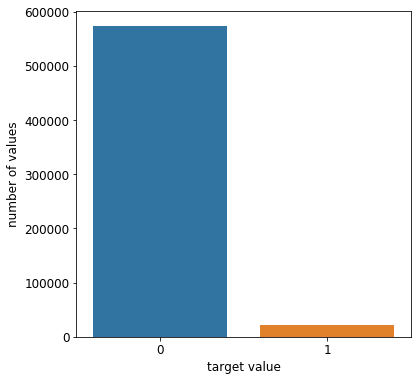

In [14]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# target value별 데이터 개수 - barplot
x = trainset['target'].value_counts().index.values
y = trainset['target'].value_counts().values
sns.barplot(ax=ax, x=x, y=y)
plt.ylabel('number of values', fontsize=12)
plt.xlabel('target value', fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

### 5.2. Real features

`ps_reg_03`, `ps_car_12`, `ps_car_14`의 최소값이 -1인 것으로 보아 missing value를 가지고 있음을 알 수 있다.

**registration features** 중 `ps_reg_01`과 `ps_reg_02`는 소수점이 깔끔히 떨어지는 것을 보아 0.1, 0.2와 같은 *분모가 10인 분수*임을 알 수 있다.

In [15]:
# real feature
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
trainset[var].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


**car features** 중 `ps_car_12`는 근사적으로 (자연수x10)의 제곱근이고 `ps_car_15`도 자연수의 제곱근이다.

In [16]:
(pow(trainset['ps_car_12']*10, 2)).head(10)

0    16.00
1    10.00
2    10.00
3    14.00
4     9.99
5    19.89
6    10.00
7    19.98
8    16.00
9    20.00
Name: ps_car_12, dtype: float64

In [17]:
(pow(trainset['ps_car_15'], 2)).head(10)

0    13.0
1     6.0
2    11.0
3     4.0
4     4.0
5     9.0
6    10.0
7    11.0
8     8.0
9    13.0
Name: ps_car_15, dtype: float64

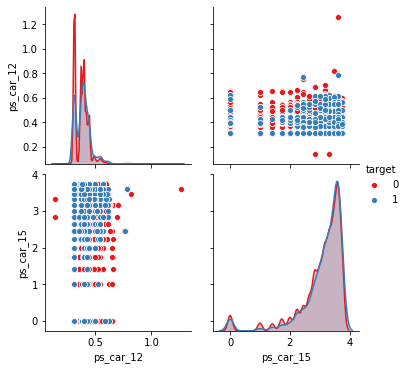

In [18]:
sample = trainset.sample(frac=0.05)   # 데이터 일부만 추출
var = ['ps_car_12', 'ps_car_15', 'target']
sample = sample[var]

# ps_car_12와 ps_car_15, target의 관계 - pairplot
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

**calculated features**의 최대값이 모두 0.9인 것으로 보아 `ps_calc_01`, `ps_calc_02`, `ps_calc_03`은 매우 비슷한 분포를 갖고 있다고 볼 수 있다. 다른 calculated features는 최대값으로 5, 6, 7, 10, 12를 갖는다.

<Figure size 432x288 with 0 Axes>

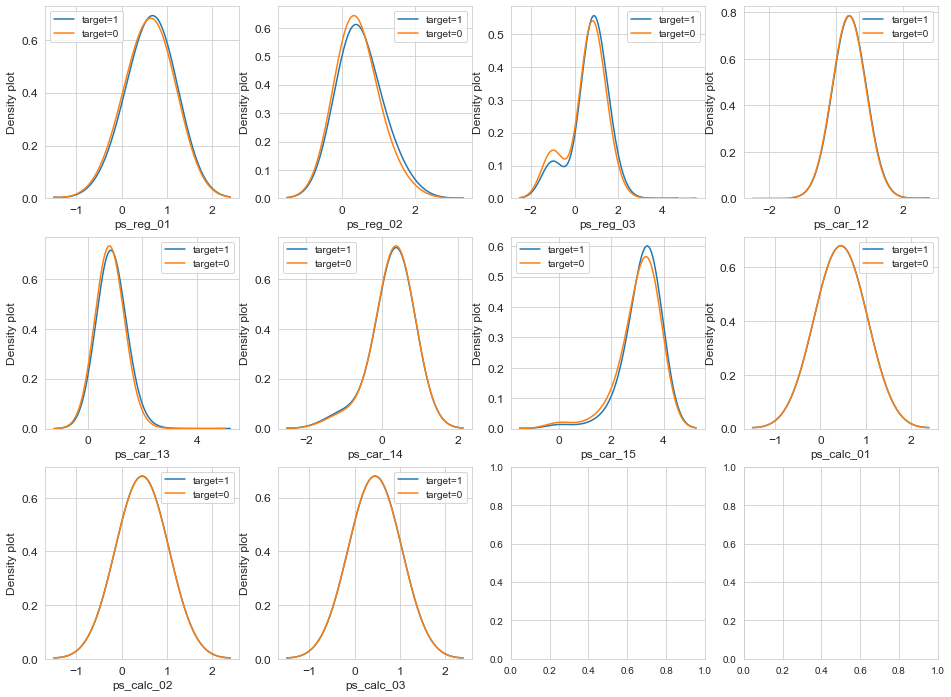

In [19]:
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
t1 = trainset.loc[trainset['target'] == 1]    # target=1인 데이터 
t0 = trainset.loc[trainset['target'] == 0]    # target=0인 데이터

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(3, 4, figsize=(16, 12))

# calculated features의 각 target value별 분포 - kdeplot
for i, feature in enumerate(var):
    plt.subplot(3, 4, i+1)
    sns.kdeplot(t1[feature], bw=0.5, label='target=1')
    sns.kdeplot(t0[feature], bw=0.5, label='target=0')
    plt.ylabel('Density plot', fontsize=12)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)

plt.show()

`ps_reg_02`, `ps_car_13`, `ps_car_15`는 *target=0*과 *target=1*일 떄의 분포가 차이가 있음을 볼 수 있다.

In [20]:
# heatmap을 그리는 함수
def corr_heatmap(var):
    correlations = trainset[var].corr()
    
    # 두 color 사이의 colormap 생성
    cmap = sns.diverging_palette(50, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=0.5, annot=True, cbar_kws={'shrink':.75})
    plt.show()

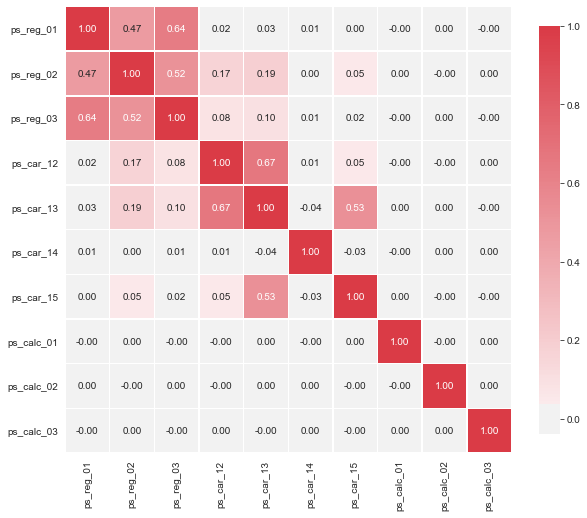

In [21]:
# real features들의 상관관계 - heatmap
var = metadata[(metadata.type == 'real') & (metadata.preserve)].index
corr_heatmap(var)

다음의 calculated feature의 쌍들은 **강한 상관관계**를 보인다.
* `ps_reg_01`과 `ps_reg_02` : 0.47
* `ps_reg_01`과 `ps_reg_03` : 0.64
* `ps_reg_02`과 `ps_reg_03` : 0.52
* `ps_car_12`와 `ps_car_13` : 0.67
* `ps_car_13`와 `ps_car_15` : 0.53

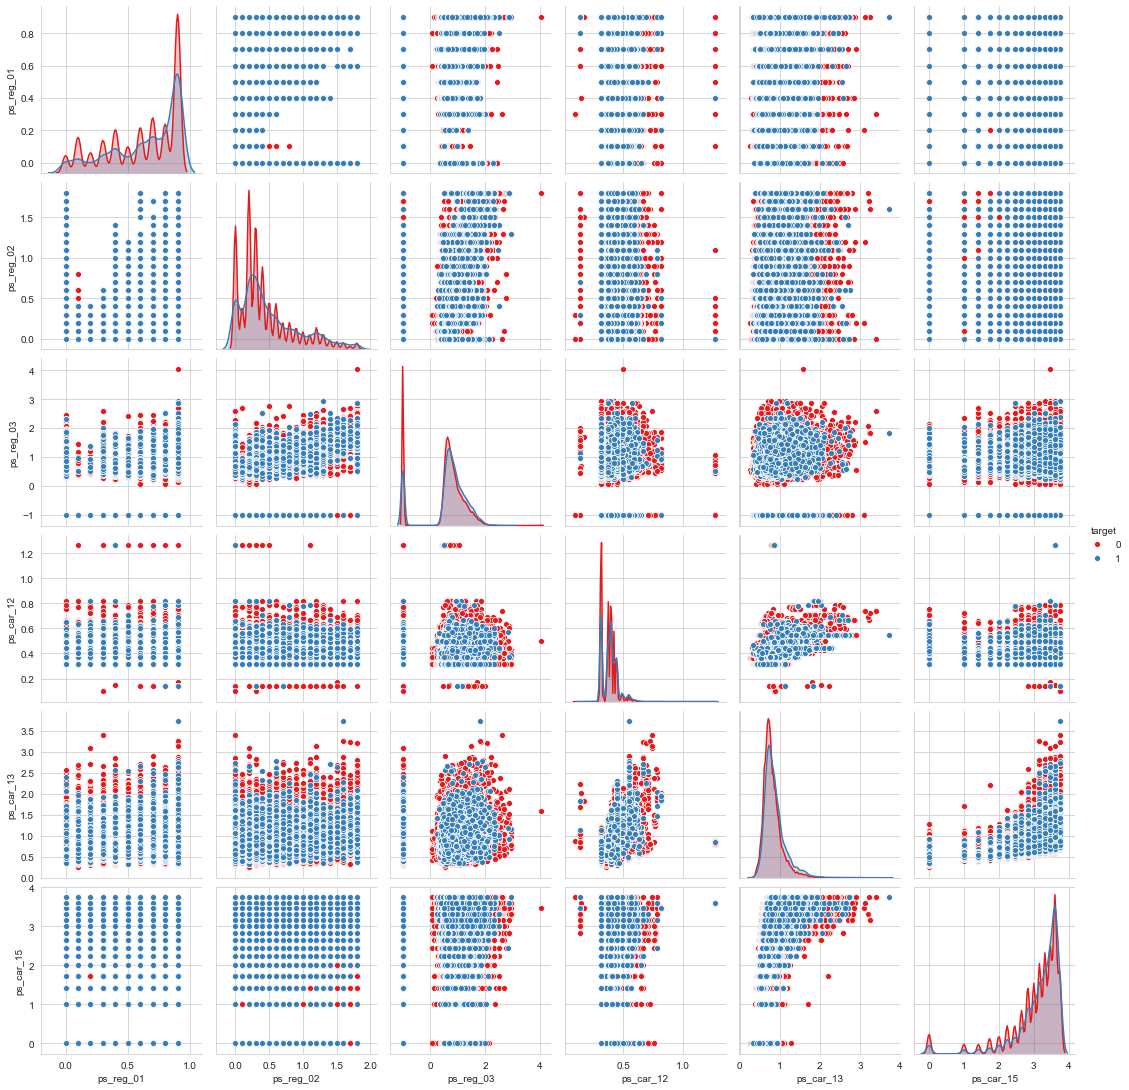

In [22]:
sample = trainset.sample(frac=0.5)    # 일부만 추출
var = ['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'target']
sample = sample[var]

# 상관관계가 높은 real features들의 관계 - pairplot
sns.pairplot(sample, hue='target', palette='Set1', diag_kind='kde')
plt.show()

### 5.3. Binary features

In [23]:
# binary features
var = metadata[(metadata.type == 'binary') & (metadata.preserve)].index
trainset[var].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [29]:
# target을 제외한 binary features
var = metadata[(metadata.type == 'binary') & (metadata.use == 'input') & (metadata.preserve)].index
# 0과 1의 비율을 저장할 리스트
zero_list, one_list = list(), list()

for feature in var:
    zero_list.append((trainset[feature] == 0).sum() / trainset.shape[0] * 100)
    one_list.append((trainset[feature] == 1).sum() / trainset.shape[0] * 100)

<Figure size 432x288 with 0 Axes>

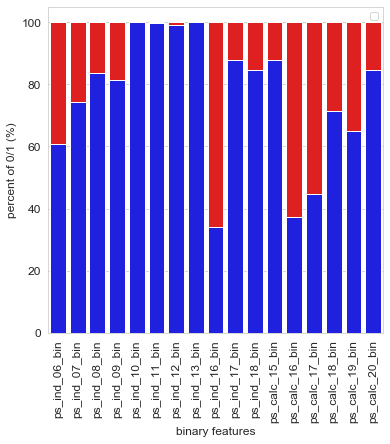

In [34]:
plt.figure()
fig, ax = plt.subplots(figsize=(6, 6))

# binary feature의 0과 1의 비율 - barplot
p1 = sns.barplot(ax=ax, x=list(var), y=zero_list, color='blue')
p2 = sns.barplot(ax=ax, x=list(var), y=one_list, bottom=zero_list, color='red')
plt.ylabel('percent of 0/1 (%)', fontsize=12)
plt.xlabel('binary features', fontsize=12)
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend((p1, p2), ('zero', 'one'))
plt.show()

`ps_ind_10_bin`, `ps_ind_11_bin`, `ps_ind_12_bin`, `ps_ind_13_bin`의 1의 비율은 **0.5%**가 안될 정도로 매우 작고, `ps_ind_16_bin`, `ps_calc_16_bin`은 1의 비율이 **60%**가 넘는다.